## Setup

In [2]:
### Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({'font.size': 17}) # Increase font size of plt plots

In [3]:
### Variable name to full name dictionary
var_dict = {
    'UNRATE' : 'Unemployment Rate',
    'INDPRO' : 'Industrial Production',
    'PCEPI' : 'Inflation',
    'FEDFUNDS' : 'Federal Funds Rate',
    'S&P 500' : 'S&P 500',
    'RCON' : 'Personal Consumption',
    'PAYEMS' : 'Payroll Employment',
    'RPI' : 'Personal Income',
    'AVGEARN' : 'Average Hourly Earnings',
    'HOUST' : 'Housing Starts',
    'CUMFNS' : 'Capacity Utilization',
    'REALLN' : 'Real Estate Loans',
    'BUSLOANS' : 'C&I Loans'
}

#### Reproduction data

In [ ]:
### Apply transformations:
# Souce: FRED-Databases Matlab code from https://research.stlouisfed.org/econ/mccracken/fred-databases/
def transform_data(x, tcode):
    # Number of observations (including missing values)
    n = len(x)
    
    # Value close to zero
    small = 1e-6
    
    # Allocate output variable
    y = np.full(n, np.nan)
    
    # Transformation based on the given code (tcode)
    if tcode == 1:
        # Level (i.e., no transformation): x(t)
        y = x
    
    elif tcode == 2:
        # First difference: x(t) - x(t-1)
        y[1:] = x[1:] - x[:-1]
    
    elif tcode == 3:
        # Second difference: (x(t) - x(t-1)) - (x(t-1) - x(t-2))
        y[2:] = x[2:] - 2 * x[1:-1] + x[:-2]
    
    elif tcode == 4:
        # Natural log: ln(x)
        if np.min(x) < small:
            y = np.full(n, np.nan)
        else:
            y = np.log(x)
    
    elif tcode == 5:
        # First difference of natural log: ln(x) - ln(x-1)
        if np.min(x) > small:
            x = np.log(x)
            y[1:] = x[1:] - x[:-1]
    
    elif tcode == 6:
        # Second difference of natural log: (ln(x) - ln(x-1)) - (ln(x-1) - ln(x-2))
        if np.min(x) > small:
            x = np.log(x)
            y[2:] = x[2:] - 2 * x[1:-1] + x[:-2]
    
    elif tcode == 7:
        # First difference of percent change: (x(t)/x(t-1)-1)-(x(t-1)/x(t-2)-1)
        y1 = np.full(n, np.nan)
        y1[1:] = (x[1:] - x[:-1]) / x[:-1]
        y[2:] = y1[2:] - y1[1:-1]
    
    return y

In [ ]:
### FREDM Data
def read_FREDM_data():
    # Start with the first release vintage of 1999-08 which contains 1959-1999 data
    data = pd.read_csv("gz-data/FRED-MD/1999-08.csv")

    feature_names = ['sasdate', 'UNRATE', 'INDPRO', 'FEDFUNDS', 'S&P 500', 'PAYEMS', 'RPI', 'CES0600000008', 'HOUST', 'CUMFNS', 'REALLN', 'BUSLOANS']
    data = data[feature_names]

    data['PCEPI'] = np.nan # PCEPI starts later, so it needs to be initialized to NaN values

    # Keep track of columns with NaN values in a set
    NaN_cols = set()

    year = 1999
    month = 9
    while year <= 2015:
        if year == 2015 and month > 8:  # Break if we exceed the last vintage
            break

        if year == 2000 and month == 8:  # Start reading the PCEPI entries
            new_data = pd.read_csv(f"gz-data/FRED-MD/2000-08.csv")
            data['PCEPI'] = new_data['PCEPI']
            feature_names.append('PCEPI')

        if month < 10:
            name = f"{year}-0{month}.csv"
        else:
            name = f"{year}-{month}.csv"

        new_data = pd.read_csv(f"gz-data/FRED-MD/{name}")
        new_row = new_data[feature_names].iloc[-1]

        # Append new row to the data DataFrame
        data = pd.concat([data, pd.DataFrame([new_row], columns=feature_names)], ignore_index=True)

        # Check for missing values in the new row
        if new_row.isnull().values.any():
            missing_cols = list(new_row[new_row.isnull().values].index)
            NaN_cols.update(missing_cols)

        # Attempt to fill NaN values in previous rows
        if NaN_cols:
            for col in list(NaN_cols):
                if not np.isnan(new_row[col]):
                    NaN_cols.remove(col)
                    # Go backwards to fill NaN values in this column
                    for i in range(len(data) - 2, -1, -1):
                        if np.isnan(data.at[i, col]):
                            data.at[i, col] = new_data.at[i, col]
                        else:
                            break

        # Increment month and handle year transition
        month += 1
        if month > 12:
            month = 1
            year += 1

    return data

In [ ]:
def read_phili_fed():
    phil_df = pd.read_csv("gz-data/Philadelphia-Fed-real-time/rconmMvMd.csv")
    data = phil_df[['DATE', 'RCONM99M9']].dropna()
    data.rename(columns={'RCONM99M9': 'RCON'}, inplace=True)
    
    year = 99
    month = 10
    while True:
        if year >= 4 and month > 1 and year < 99:
            break
        if year < 10:
            col = f"RCONM0{year}M{month}"
        else:
            col = f"RCONM{year}M{month}"
        new_data = phil_df[['DATE', col]].dropna().values
        data.loc[len(data.index)] = new_data[-1]
        month += 1
        if month > 12:
            month = 1
            year += 1
            if year == 100:
                year = 0
    data['RCON'] = data['RCON'].apply(lambda x: float(x.replace(",", ""))) # Translate strings into integers
    return data['RCON']

In [ ]:
# Load data
data = read_FREDM_data()
data = data.drop(data.index[0]) # remove the tcodes given in the data
data['RCON'] = read_phili_fed()

# Transformation codes given in the online appendix
transformation_dict = {
    'UNRATE': 2,
    'INDPRO': 5,
    'PCEPI': 5,
    'FEDFUNDS': 2,
    'S&P 500': 5,
    'RCON': 5, 
    'PAYEMS': 5,
    'RPI': 5,
    'CES0600000008': 5,
    'HOUST': 5,
    'CUMFNS': 2,
    'REALLN': 5,
    'BUSLOANS': 5
}

# Apply transformations
for i, col in enumerate(data.columns):
    if col == 'sasdate':
        continue
    if col == 'REALLN' or col == 'BUSLOANS' or col == 'RCON': # These columns have missing values
        mask = data[col].notnull()
        data.loc[mask, col] = transform_data(np.array(data.loc[mask, col]), transformation_dict[col])
    else:
        data[col] = transform_data(np.array(data[col]), transformation_dict[col])

data.rename(columns={'CES0600000008': 'AVGEARN'}, inplace=True)

In [ ]:
for col in data.columns:
    if col == 'sasdate':
        continue
    plt.figure(figsize=(20, 6))
    plt.plot(pd.to_datetime(data['sasdate']), data[col], linewidth=0.6)
    plt.title(col)
    plt.axvline(pd.to_datetime('01-01-1999'), color='black', linewidth=0.5) # train-test split
    plt.axvline(pd.to_datetime('01-01-2008'), color='pink', linewidth=0.5) # 2008 recession
    plt.xlim(pd.to_datetime(data['sasdate']).min(), pd.to_datetime(data['sasdate']).max())
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Save transformed data to CSV
# data.to_csv("data.csv", index=False)

#### Extended data

In [ ]:
### FREDM Data
def read_FREDM_data_covid():
    # Start with the first release vintage of 1999-08 which contains 1959-1999 data
    data = pd.read_csv("gz-data/FRED-MD/1999-08.csv")

    feature_names = ['sasdate', 'UNRATE', 'INDPRO', 'FEDFUNDS', 'S&P 500', 'PAYEMS', 'RPI', 'CES0600000008', 'HOUST', 'CUMFNS', 'REALLN', 'BUSLOANS']
    data = data[feature_names]

    data['PCEPI'] = np.nan # PCEPI starts later, so it needs to be initialized to NaN values

    # Keep track of columns with NaN values in a set
    NaN_cols = set()

    year = 1999
    month = 9
    while year <= 2024:
        if year == 2024 and month > 4:  # Break if we exceed the last vintage
            break

        if year == 2000 and month == 8:  # Start reading the PCEPI entries
            new_data = pd.read_csv(f"gz-data/FRED-MD/2000-08.csv")
            data['PCEPI'] = new_data['PCEPI']
            feature_names.append('PCEPI')

        if month < 10:
            name = f"{year}-0{month}.csv"
        else:
            name = f"{year}-{month}.csv"

        new_data = pd.read_csv(f"gz-data/FRED-MD/{name}")
        new_row = new_data[feature_names].iloc[-1]

        # Append new row to the data DataFrame
        data = pd.concat([data, pd.DataFrame([new_row], columns=feature_names)], ignore_index=True)

        # Check for missing values in the new row
        if new_row.isnull().values.any():
            missing_cols = list(new_row[new_row.isnull().values].index)
            NaN_cols.update(missing_cols)

        # Attempt to fill NaN values in previous rows
        if NaN_cols:
            for col in list(NaN_cols):
                if not np.isnan(new_row[col]):
                    NaN_cols.remove(col)
                    # Go backwards to fill NaN values in this column
                    for i in range(len(data) - 2, -1, -1):
                        if np.isnan(data.at[i, col]):
                            data.at[i, col] = new_data.at[i, col]
                        else:
                            break

        # Increment month and handle year transition
        month += 1
        if month > 12:
            month = 1
            year += 1

    return data

In [ ]:
def read_phili_fed_covid():
    phil_df = pd.read_csv("gz-data/Philadelphia-Fed-real-time/rconmMvMd.csv")
    data = phil_df[['DATE', 'RCONM99M9']].dropna()
    data.rename(columns={'RCONM99M9': 'RCON'}, inplace=True)
    
    year = 99
    month = 10
    while True:
        if year == 21 and month == 1 and year < 99: # Break if we exceed the last vintage
            break

        # Transform date and year to correct format
        if year < 10:
            col = f"RCONM0{year}M{month}"
        else:
            col = f"RCONM{year}M{month}"

        new_data = phil_df[['DATE', col]].dropna().values

        data.loc[len(data.index)] = new_data[-1]
        month += 1
        if month > 12:
            month = 1
            year += 1
            if year == 100:
                year = 0
    data['RCON'] = data['RCON'].apply(lambda x: float(x.replace(",", ""))) # Translate strings into integers
    return data['RCON']

In [ ]:
# Load data
data = read_FREDM_data_covid()
data = data.drop(data.index[0]) # remove the tcodes given in the data
data['RCON'] = read_phili_fed_covid()

# Transformation codes given in the online appendix
transformation_dict = {
    'UNRATE': 2,
    'INDPRO': 5,
    'PCEPI': 5,
    'FEDFUNDS': 2,
    'S&P 500': 5,
    'RCON': 5, 
    'PAYEMS': 5,
    'RPI': 5,
    'CES0600000008': 5,
    'HOUST': 5,
    'CUMFNS': 2,
    'REALLN': 5,
    'BUSLOANS': 5
}

# Apply transformations
for i, col in enumerate(data.columns):
    if col == 'sasdate':
        continue
    if col == 'REALLN' or col == 'BUSLOANS' or col == 'RCON': # These columns have missing values
        mask = data[col].notnull()
        data.loc[mask, col] = transform_data(np.array(data.loc[mask, col]), transformation_dict[col])
    else:
        data[col] = transform_data(np.array(data[col]), transformation_dict[col])

data.rename(columns={'CES0600000008': 'AVGEARN'}, inplace=True)

#### Plots used in the paper

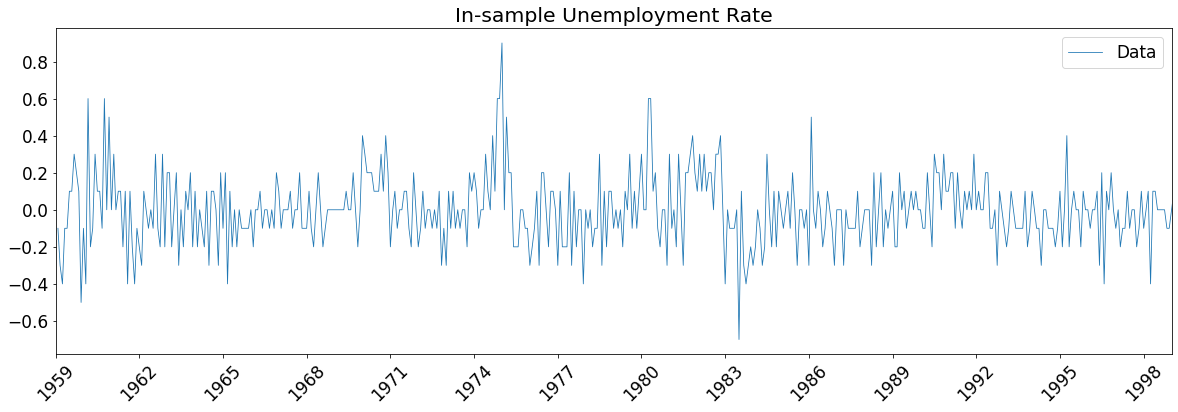

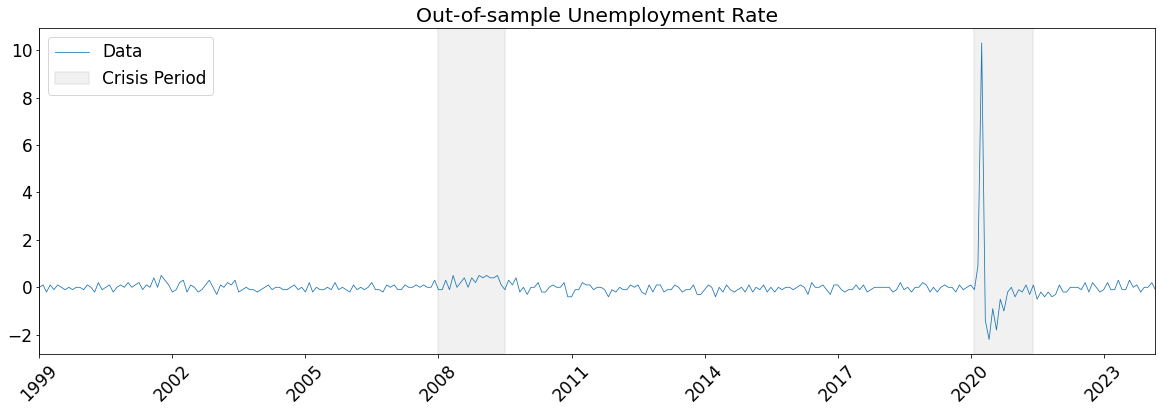

In [32]:
col = 'UNRATE'
plt.figure(figsize=(20, 6))
plt.plot(pd.to_datetime(data['sasdate']).iloc[:487], data[col].iloc[:487], linewidth=0.8, label='Data')
plt.title('In-sample Unemployment Rate')
plt.axvline(pd.to_datetime('01-01-1999'), color='black', linewidth=0.5) # train-test split
plt.xlim(pd.to_datetime(data['sasdate']).min(), pd.to_datetime('01-01-1999'))
years = pd.date_range(pd.to_datetime(data['sasdate']).min(), pd.to_datetime('01-01-1999'), freq='3YS')
plt.xticks(years, [year.year for year in years], rotation=45)
plt.legend()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(pd.to_datetime(data['sasdate']), data[col], linewidth=0.8, label='Data')
plt.title('Out-of-sample Unemployment Rate')
plt.axvline(pd.to_datetime('01-01-1999'), color='black', linewidth=0.5) # train-test split
plt.axvspan(pd.to_datetime('01-01-2008'), pd.to_datetime('07-01-2009'), color='lightgrey', alpha=0.3, lw=2, label='Crisis Period')
plt.axvspan(pd.to_datetime('02-01-2020'), pd.to_datetime('06-01-2021'), color='lightgrey', alpha=0.3, lw=2)
# plt.xlim(pd.to_datetime(data['sasdate']).min(), pd.to_datetime(data['sasdate']).max())
plt.xlim(pd.to_datetime('01-01-1999'), pd.to_datetime(data['sasdate']).max())
# years = pd.date_range(start=pd.to_datetime(data['sasdate']).min(), end=pd.to_datetime(data['sasdate']).max(), freq='5YS')
years = pd.date_range(start=pd.to_datetime('01-01-1999'), end=pd.to_datetime(data['sasdate']).max(), freq='3YS')
plt.xticks(years, [year.year for year in years], rotation=45)
plt.legend()
plt.show()

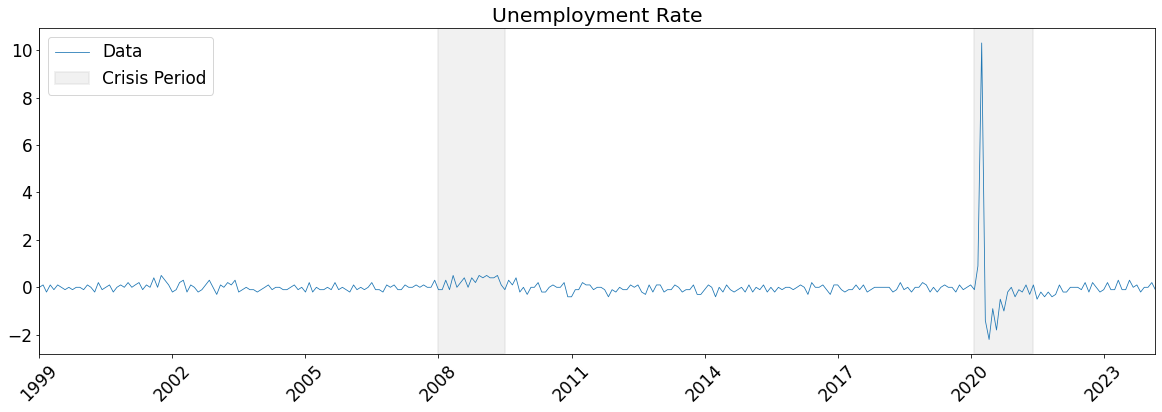

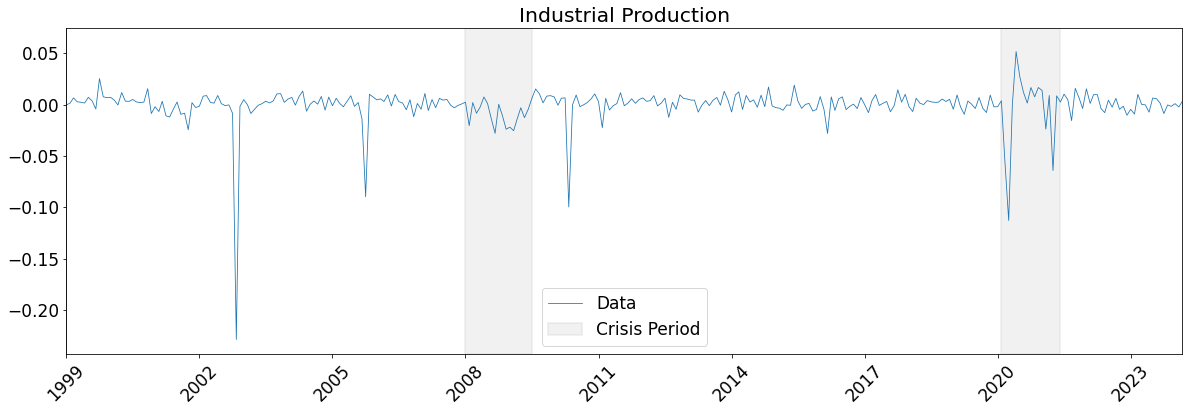

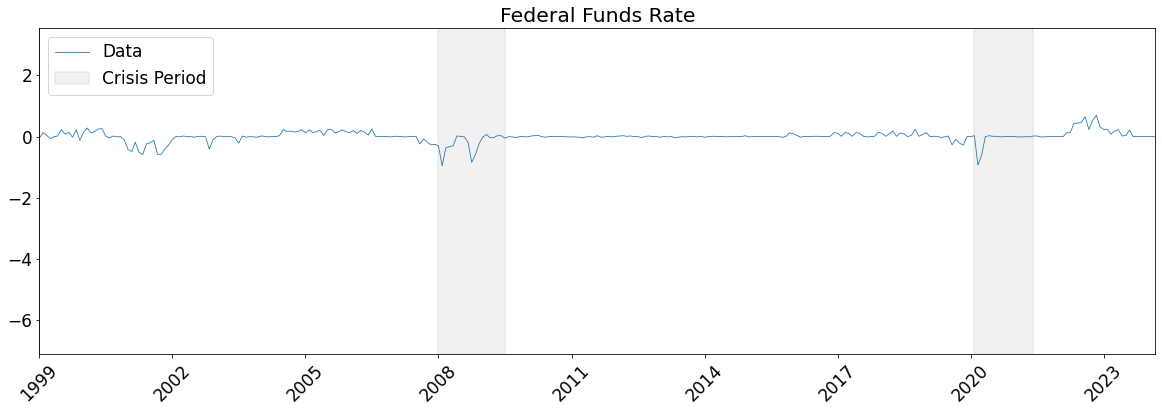

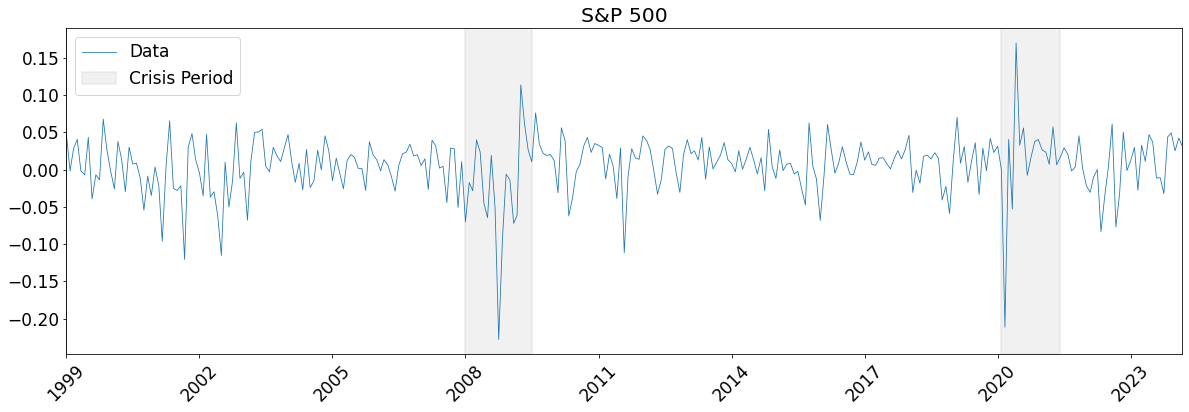

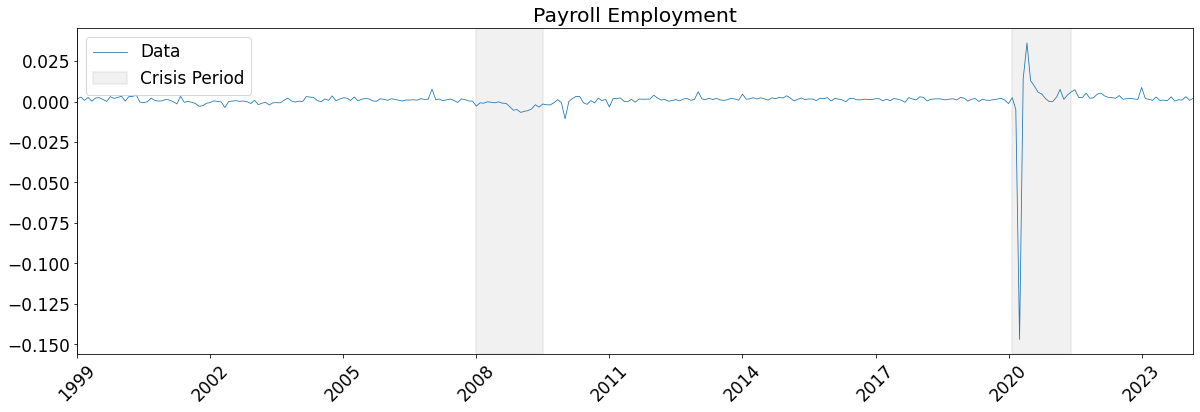

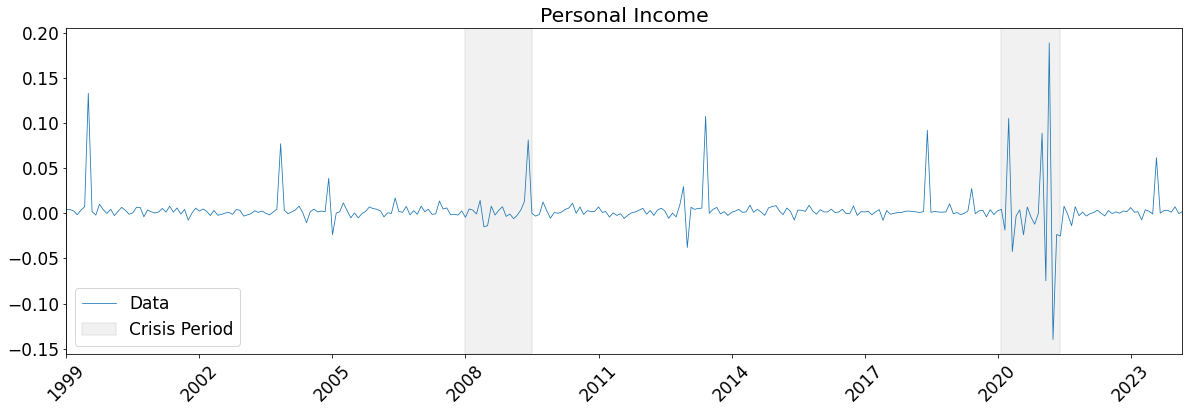

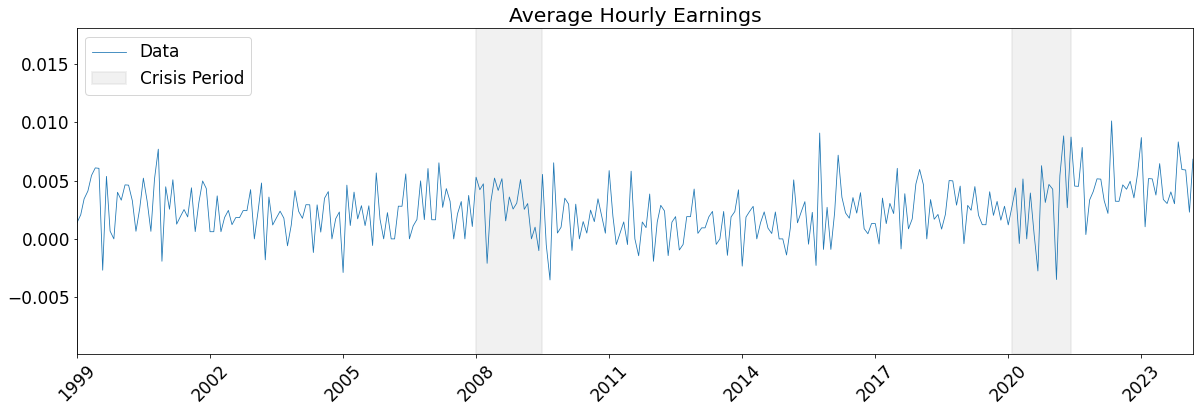

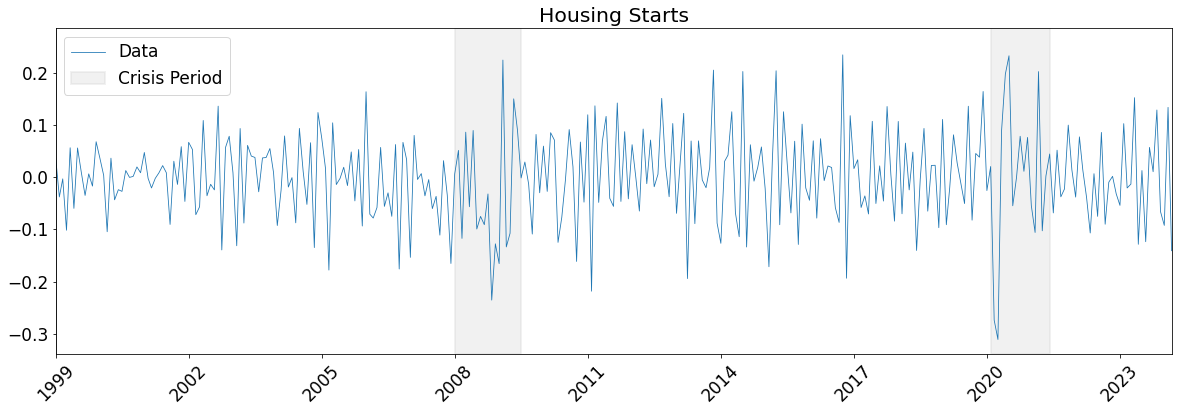

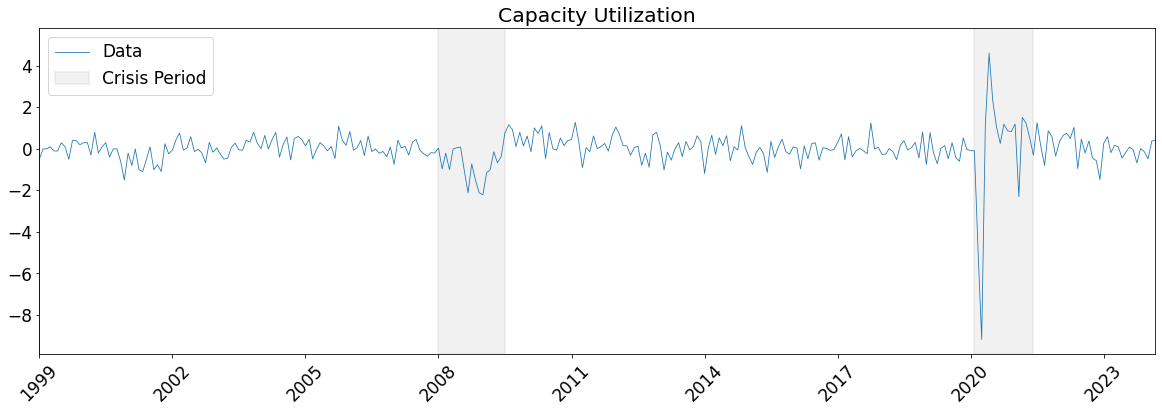

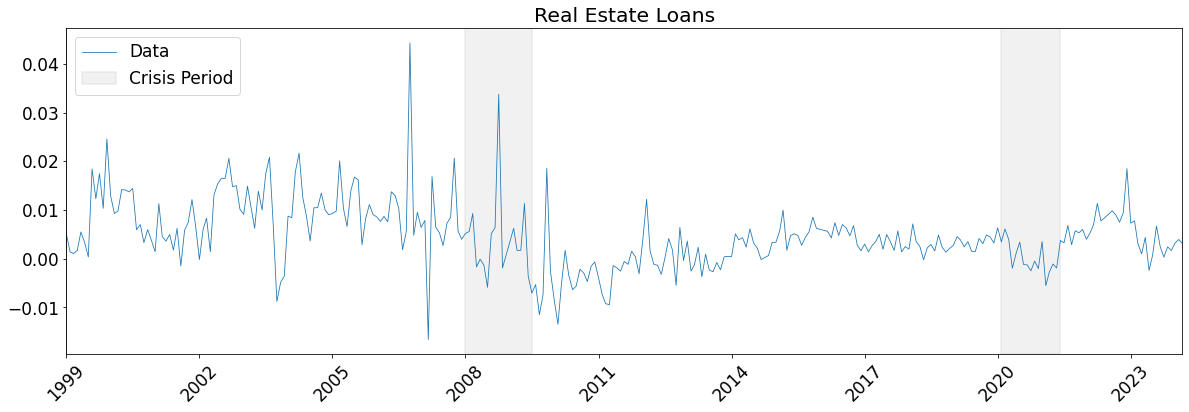

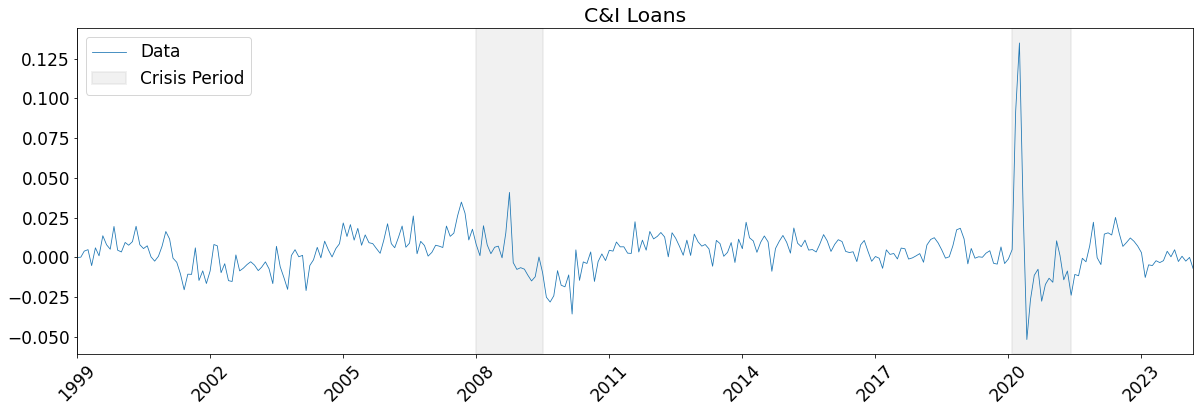

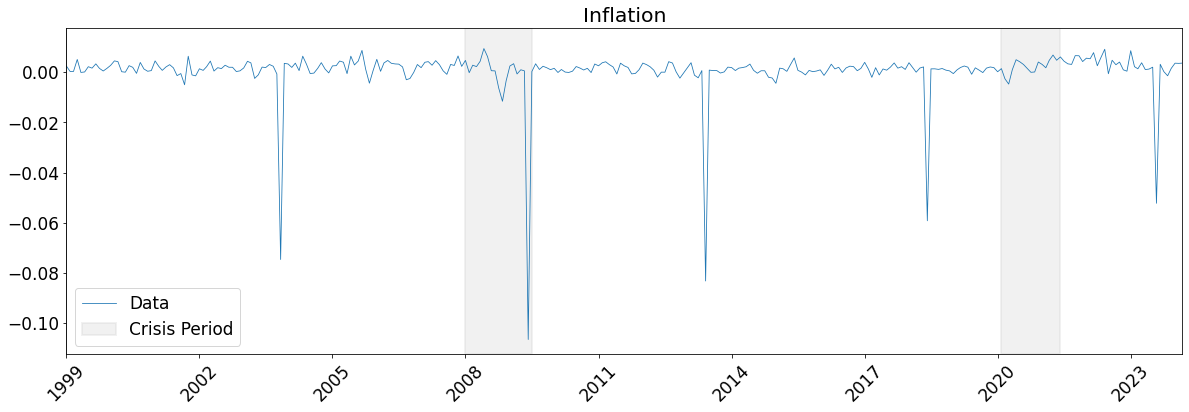

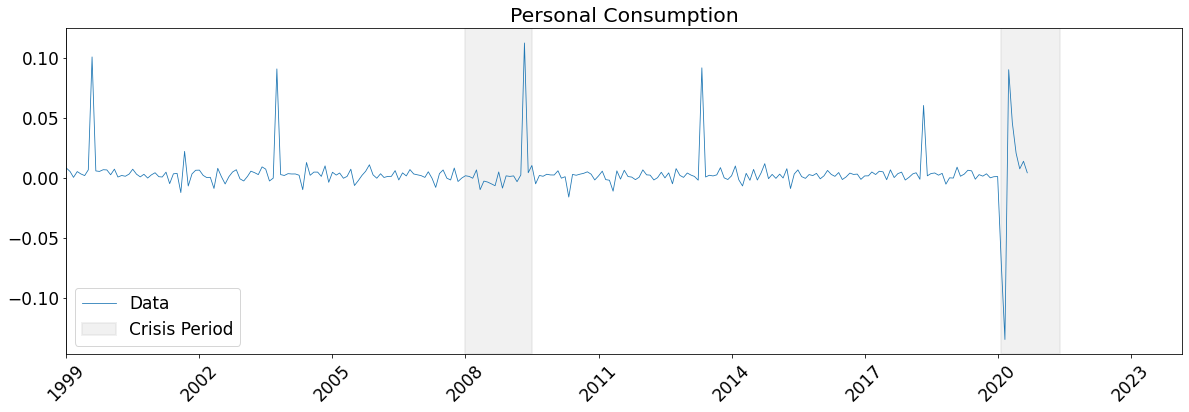

In [24]:
data = pd.read_csv("data_extended.csv")
for col in data.columns:
    if col == 'sasdate':
        continue
    plt.figure(figsize=(20, 6))
    plt.plot(pd.to_datetime(data['sasdate']), data[col], linewidth=0.8, label='Data')
    plt.title(var_dict[col])
    plt.axvline(pd.to_datetime('01-01-1999'), color='black', linewidth=0.5) # train-test split
    plt.axvspan(pd.to_datetime('01-01-2008'), pd.to_datetime('07-01-2009'), color='lightgrey', alpha=0.3, lw=2, label='Crisis Period')
    plt.axvspan(pd.to_datetime('02-01-2020'), pd.to_datetime('06-01-2021'), color='lightgrey', alpha=0.3, lw=2)
    # plt.xlim(pd.to_datetime(data['sasdate']).min(), pd.to_datetime(data['sasdate']).max())
    plt.xlim(pd.to_datetime('01-01-1999'), pd.to_datetime(data['sasdate']).max())
    # years = pd.date_range(start=pd.to_datetime(data['sasdate']).min(), end=pd.to_datetime(data['sasdate']).max(), freq='5YS')
    years = pd.date_range(start=pd.to_datetime('01-01-1999'), end=pd.to_datetime(data['sasdate']).max(), freq='3YS')
    plt.xticks(years, [year.year for year in years], rotation=45)
    plt.legend()
    plt.show()

In [ ]:
# Save data to CSV
# data.to_csv("data_extended.csv", index=False)